In [8]:
!pip install reportlab 


In [10]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
from reportlab.lib.pagesizes import letter
from reportlab.pdfgen import canvas
from datetime import datetime
import seaborn as sns
from scipy.stats import norm

In [12]:
# Fetch stock data
def fetch_stock_data(ticker='STAN.L', start='2024-01-01', end='2025-01-01'):
    stock_data = yf.download(ticker, start=start, end=end)
    return stock_data

In [28]:
# Calculate financial metrics
def calculate_metrics(stock_data):
    daily_returns = stock_data['Close'].pct_change().dropna()
    mean_return = daily_returns.mean()
    annualized_return = (1 + mean_return) ** 252 - 1  # Annualized return
    volatility = daily_returns.std() * (252 ** 0.5)  # Annualized volatility
    sharpe_ratio = mean_return / daily_returns.std() * np.sqrt(252)  # Sharpe ratio
    max_drawdown = (stock_data['Close'].cummax() - stock_data['Close']).max()

    # Beta (using market data like S&P 500)
    sp500 = yf.download('^GSPC', start=stock_data.index[0], end=stock_data.index[-1])
    sp500_returns = sp500['Close'].pct_change().dropna()
    covariance = np.cov(daily_returns[1:], sp500_returns[1:])[0, 1]
    market_variance = np.var(sp500_returns[1:])
    beta = covariance / market_variance

    # Calculate Value at Risk (VaR)
    var_95 = np.percentile(daily_returns, 5) * np.sqrt(252)  # 95% Confidence Level

    # Conditional VaR (CVaR)
    cvar_95 = daily_returns[daily_returns <= var_95].mean() * np.sqrt(252)

    # Sortino Ratio
    downside_returns = daily_returns[daily_returns < 0]
    sortino_ratio = mean_return / downside_returns.std() * np.sqrt(252)  # Sortino ratio

    return float(annualized_return), float(volatility), float(sharpe_ratio), float(beta), float(max_drawdown), float(var_95), float(cvar_95), float(sortino_ratio)

In [20]:
# Generate a plot to include in the report
def generate_plot(stock_data, ticker='STAN.L'):
    plt.figure(figsize=(10, 6))
    plt.plot(stock_data['Close'], label='Close Price')
    plt.title(f'{ticker} Stock Performance')
    plt.legend()
    filename = f"{ticker}_stock_performance.png"
    plt.savefig(filename)
    return filename

In [22]:
# Generate the PDF report
def generate_pdf(stock_data, annualized_return, volatility, sharpe_ratio, beta, max_drawdown, var_95, cvar_95, sortino_ratio, filename='financial_report.pdf'):
    c = canvas.Canvas(filename, pagesize=letter)

    # Title
    c.setFont("Helvetica", 18)
    c.drawString(200, 750, f"Advanced Financial Analysis Report: Standard Chartered Bank")

    # Add date to the report
    c.setFont("Helvetica", 12)
    c.drawString(50, 720, f"Report generated on: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

    # Add stock overview
    c.drawString(50, 700, f"Stock: {ticker}")
    c.drawString(50, 680, f"Start Date: {stock_data.index[0].strftime('%Y-%m-%d')}")
    c.drawString(50, 660, f"End Date: {stock_data.index[-1].strftime('%Y-%m-%d')}")
# Add key metrics
    c.drawString(50, 640, f"Key Financial Metrics:")
    c.drawString(50, 620, f"Annualized Return: {annualized_return*100:.2f}%")
    c.drawString(50, 600, f"Annualized Volatility: {volatility:.2f}")
    c.drawString(50, 580, f"Sharpe Ratio: {sharpe_ratio:.2f}")
    c.drawString(50, 560, f"Beta: {beta:.2f}")
    c.drawString(50, 540, f"Max Drawdown: {max_drawdown:.2f}")
    c.drawString(50, 520, f"Value at Risk (VaR): {var_95:.2f}%")
    c.drawString(50, 500, f"Conditional VaR (CVaR): {cvar_95:.2f}%")
    c.drawString(50, 480, f"Sortino Ratio: {sortino_ratio:.2f}")

    # Add the plot to the PDF
    plot_filename = generate_plot(stock_data, ticker)
    c.drawImage(plot_filename, 50, 350, width=500, height=250)
    
    # Save the PDF
    c.save()

In [24]:
# Automate report generation
def automate_report_generation(ticker='STAN.L'):
    stock_data = fetch_stock_data(ticker)
    annualized_return, volatility, sharpe_ratio, beta, max_drawdown, var_95, cvar_95, sortino_ratio = calculate_metrics(stock_data)
    report_filename = f"financial_report_{ticker}_{datetime.now().strftime('%Y%m%d%H%M%S')}.pdf"
    generate_pdf(stock_data, annualized_return, volatility, sharpe_ratio, beta, max_drawdown, var_95, cvar_95, sortino_ratio, report_filename)
    print(f"Automated report generated: {report_filename}")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
C:\Users\teka\AppData\Local\Temp\ipykernel_10856\4062101230.py:13: RuntimeWarning: Degrees of freedom <= 0 for slice
  covariance = np.cov(daily_returns[1:], sp500_returns[1:])[0, 1]
D:\anaconder\Lib\site-packages\numpy\lib\function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
D:\anaconder\Lib\site-packages\numpy\lib\function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
D:\anaconder\Lib\site-packages\numpy\core\fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return var(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
C:\Users\teka\AppData\Local\Temp\ipykernel

Automated report generated: financial_report_STAN.L_20250328173549.pdf


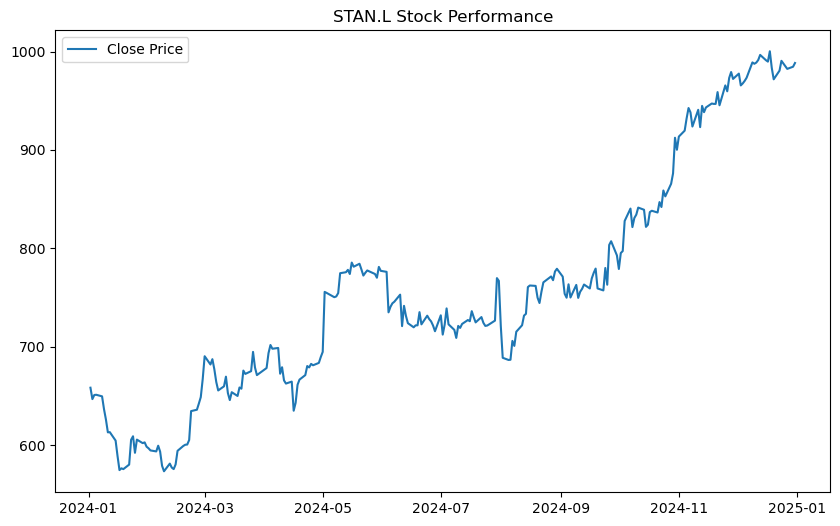

In [30]:
# Schedule this function to run periodically
automate_report_generation()  # Run the function to generate the report
